In [1]:
# Notebook to search Cheminventory DB (as excel file)
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdChemReactions
from rdkit import DataStructs
from itertools import product
import numpy as np

In [2]:
# read in XChem and Naismith ChemInventory excel files
Xchem_inv = pd.read_excel('/home/warren/XChem_projects/xchem-CovidOT/in_data/XChemInventory.xlsx')
Naismith_inv = pd.read_excel('/home/warren/XChem_projects/xchem-CovidOT/in_data/NaismithInventory.xlsx')

In [3]:
chem_inv =  pd.concat([Xchem_inv, Naismith_inv], ignore_index=True, sort=False)

In [4]:
chem_inv.head()

,Container Name,Substance CAS,Container Size,Unit,Barcode,Supplier,Comments,Location,Date Acquired,SMILES,Molecular Weight,Molecular Formula
0,"(1S,4S)-2,5-diazabicyclo[2.2.1]heptane dihydro...",5260-20-8,100.2,mg,EN300-343647,Enamine,C7,RCaH XChem > RCaH XChem > RCaH_1.27_XChem > Fr...,2018-02-01,C1[C@H]2CN[C@@H]1CN2.Cl.Cl,171.07,C5H12Cl2N2
1,(2-Biphenyl)di-tert-butylphosphine (JohnPhos),24311-51-7,1,g,NaN,Aldrich,NaN,RCaH XChem > RCaH XChem > RCaH_1.27_XChem > So...,2017-05-24,C1=CC=CC(C2=CC=CC=C2)=C1P(C(C)(C)C)C(C)(C)C,298.41,C20H27P
2,(2-bromoethyl)benzene,103-63-9,1005.2,mg,EN300-96843,Enamine,E2,RCaH XChem > RCaH XChem > RCaH_1.27_XChem > Ye...,2018-02-01,C1=CC=C(C=C1)CCBr,185.06,C8H9Br
3,(2-chloro-6-fluorophenyl)methanamine,15205-15-9,1004.8,mg,EN300-33074,Enamine,A5,RCaH XChem > RCaH XChem > RCaH_1.27_XChem > Fr...,2018-02-01,C1=CC(=C(C(=C1)Cl)CN)F,159.59,C7H7ClFN
4,"(2H-1,3-benzodioxol-5-yl)boronic acid",94839-07-3,1005.3,mg,EN300-212504,Enamine,B9,RCaH XChem > RCaH XChem > RCaH_1.27_XChem > Fr...,2018-02-01,B(C1=CC2=C(C=C1)OCO2)(O)O,165.94,C7H7BO4


In [5]:
# Let's write a few functions to help with the search. We need to search the DF and identify
# compounds that mathc amide synthesis 

def getamidereacts(all_info):
    """
    all_info: Tuple of mol,name, mw and location
    
    out: This function will return lists of R-NH2 reacts, R-COOH and R-COCl reacts that
         can be used in an amide coupling rxn
    """

    RCOOH_patt = Chem.MolFromSmarts('[*;!#1;!-]-[A#6](=[#8])[#8][#1]')
    RCOCl_patt =  Chem.MolFromSmarts('[*]-[A#6](=[#8])[#17]')
    RNH2_patt =  Chem.MolFromSmarts('[*;!#16;!#1]-[A#7;!R;X3]([#1])([#1])')
           
    # Remove H's
    RCOOH_data = [(Chem.RemoveHs(info[0]), info[1], info[2], info[3], info[4]) for info in all_info if info[0].HasSubstructMatch(RCOOH_patt)]  
    RCOCl_data = [(Chem.RemoveHs(info[0]), info[1], info[2], info[3], info[4]) for info in all_info if info[0].HasSubstructMatch(RCOCl_patt)]
    RNH2_data = [(Chem.RemoveHs(info[0]), info[1], info[2], info[3], info[4]) for info in all_info if info[0].HasSubstructMatch(RNH2_patt)]
    
    return RCOOH_data, RCOCl_data, RNH2_data

def reactamide(RCOOH_data, RCOCl_data, RNH2_data):
    """
    RCOOH_data, RCOCl_data, RNH2_data: Input data from of amide reagents from getamidesreacts func
    
    out: This function will return a df of all the products found
    """
    
    # Assign SMARTS reaction
    RCOOH_RNH2_reaction = rdChemReactions.ReactionFromSmarts('[#6:1](=[#8:2])-[#8].[A#7:3]>>[#6:1](=[#8:2])-[A#7:3]')
    
    # Get list of tuples of all possible pairwise reactants
    RCOOH_RNH2_react_data = list(product(RCOOH_data, RNH2_data))
    
    # Run the reaction for all the pairwise reactants found and return a tuple of 
    # product_SMILES, react_1_mol, react_1_name, react_1_mw, react_1_location, 
    # react_2_mol, react_2_name, react_2_mw, react_2_location 
    RCOOH_RNH2_prod_data = [(RCOOH_RNH2_reaction.RunReactants((react_data[0][0],react_data[1][0]))[0][0],
                             react_data[0][0],react_data[0][1],react_data[0][2],react_data[0][3],react_data[0][4],
                             react_data[1][0],react_data[1][1],react_data[1][2],react_data[1][3],react_data[1][4])
                             for react_data in RCOOH_RNH2_react_data] 
    
    # Creat pandas dataframes from tuples
    RCOOH_RNH2_prod_data = pd.DataFrame(data=RCOOH_RNH2_prod_data, columns=['product_mols', 'react_1_mol', 'react_1_name',
                                                                            'react_1_mw', 'react_1_location', 'react_1_comments', 
                                                                            'react_2_mol', 'react_2_name', 
                                                                            'react_2_mw', 'react_2_location','react_2_comments'])
       
       
    # Assign SMARTS reaction
    RCOCl_RNH2_reaction = rdChemReactions.ReactionFromSmarts('[#6:1](=[#8:2])-[#17].[A#7:3]>>[#6:1](=[#8:2])-[A#7:3]')
    
    # Get list of tuples of all possible pairwise reactants
    RCOCl_RNH2_react_data = list(product(RCOCl_data, RNH2_data))
    
    # Run the reaction for all the pairwise reactants found and return a tuple of 
    # product_SMILES, react_1_mol, react_1_name, react_1_mw, react_1_location, react_2_mol, react_2_name, react_2_mw, react_2_location 
    RCOCl_RNH2_prod_data = [(RCOCl_RNH2_reaction.RunReactants((react_data[0][0],react_data[1][0]))[0][0],
                             react_data[0][0],react_data[0][1],react_data[0][2],react_data[0][3],react_data[0][4],
                             react_data[1][0],react_data[1][1],react_data[1][2],react_data[1][3],react_data[1][4])
                             for react_data in RCOCl_RNH2_react_data]
    
    # Creat pandas dataframes from tuples
    RCOCl_RNH2_prod_data = pd.DataFrame(data=RCOCl_RNH2_prod_data, columns=['product_mols', 'react_1_mol', 'react_1_name',
                                                                            'react_1_mw', 'react_1_location','react_1_comments', 
                                                                            'react_2_mol', 'react_2_name', 
                                                                            'react_2_mw', 'react_2_location','react_2_comments'])
    
    # Concat two dfs into one
    prod_df = pd.concat([RCOOH_RNH2_prod_data, RCOCl_RNH2_prod_data], ignore_index=True, sort=False)
    
    # Create smiles column
    prod_df['product_SMILES'] = [Chem.MolToSmiles(mol) for mol in prod_df['product_mols']]
    
    # Drop duplicate product entries
    prod_df = prod_df.drop_duplicates(subset='product_SMILES', keep="first")
    
    # Need to get rid of None mols
    mols = [Chem.MolFromSmiles(smi) for smi in prod_df['product_SMILES']]
    
    # Indices of None mols
    none_indices = [index for index, mol in enumerate(mols) if mol is None]
    
    # Remove rows from df with None mols
    prod_df = prod_df.drop(prod_df.index[none_indices])
        
    return prod_df
    

In [6]:
# Get the mols, location, name and MW info from the DB as a tuple
mols = [Chem.MolFromSmiles(smi) for smi in chem_inv['SMILES']]
locations = [location for location in chem_inv['Location']]
names = [name for name in chem_inv['Container Name']]
comments = [comment for comment in chem_inv['Comments']]
mw = [mw for mw in chem_inv['Molecular Weight']]

# Zip info together into tuples (mol, name, MW and location)
all_info = tuple(zip(mols,names,mw, locations,comments))

# Remove tuple entries if mol in None and add Hydrogens to help search for starting materials
all_info = [(Chem.AddHs(info[0]),info[1],info[2],info[3],info[4]) for info in all_info if info[0] is not None]

In [7]:
# Let's now get the amide coupling reactants
RCOOH_data, RCOCl_data, RNH2_data = getamidereacts(all_info)

In [8]:
# How many compounds did we find?
print("No RCOOH compounds: {}\nNo RCOCl compounds: {}\nNo RH2 compounds: {}".format(len(RCOOH_data), len(RCOCl_data), len(RNH2_data)))

No RCOOH compounds: 269
No RCOCl compounds: 32
No RH2 compounds: 228


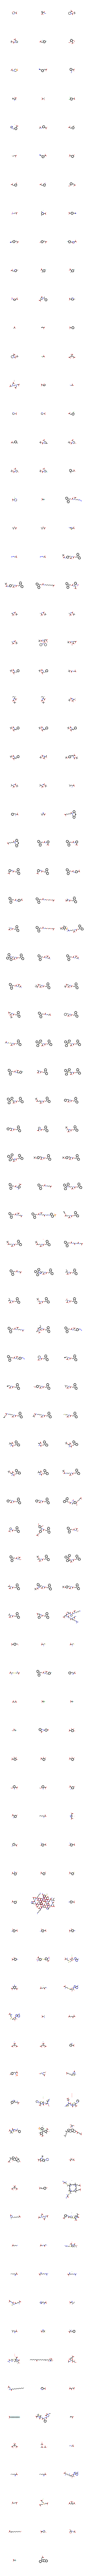

In [9]:
# For sanity check - let's see what the compounds are? 
# Change function call to see RCOOH_mols, RCOCl_mols and/or RNH2_mols
# Need to go through with Anthony to sanity check for ones we do not want
# to use

# The RCOOH reacts
Draw.MolsToGridImage([info[0] for info in RCOOH_data])

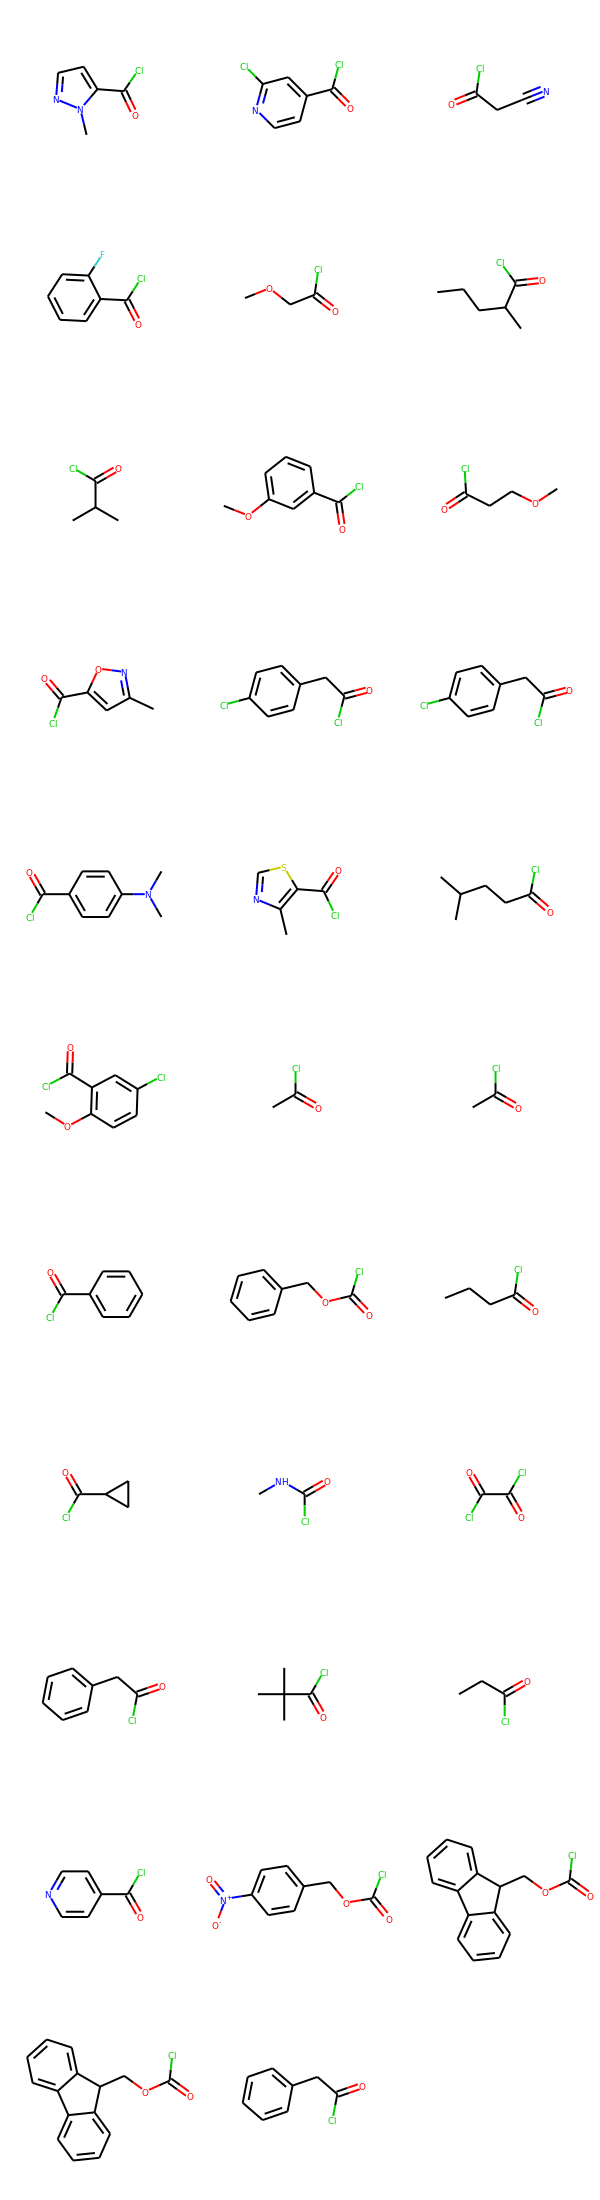

In [10]:
# The RCOCl reacts
Draw.MolsToGridImage([info[0] for info in RCOCl_data])

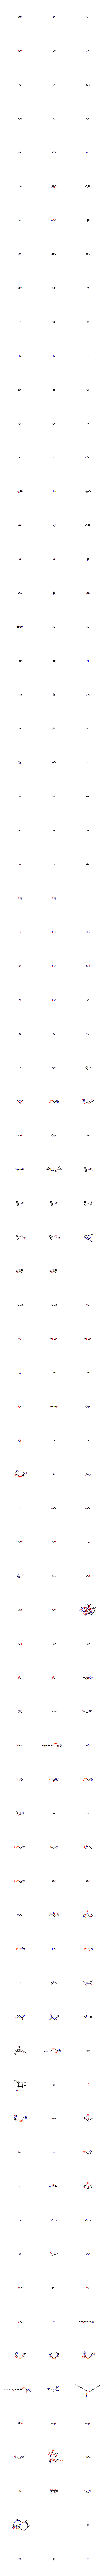

In [11]:
# The RNH2 reacts
Draw.MolsToGridImage([info[0] for info in RNH2_data])

In [12]:
# Get the amide coupling products and data
prod_df = reactamide(RCOOH_data, RCOCl_data, RNH2_data)

In [13]:
prod_df.head()

,product_mols,react_1_mol,react_1_name,react_1_mw,react_1_location,react_1_comments,react_2_mol,react_2_name,react_2_mw,react_2_location,react_2_comments,product_SMILES
0,<rdkit.Chem.rdchem.Mol object at 0x7ff977455df0>,<rdkit.Chem.rdchem.Mol object at 0x7ff977671760>,(±)-Morpholine-3-carboxylic acid hydrochloride,131.13,RCaH XChem > RCaH XChem > RCaH_1.27_XChem > Ye...,NaN,<rdkit.Chem.rdchem.Mol object at 0x7ff977478f80>,(2-chloro-6-fluorophenyl)methanamine,159.59,RCaH XChem > RCaH XChem > RCaH_1.27_XChem > Fr...,A5,O=C(NCc1c(F)cccc1Cl)C1COCCN1
1,<rdkit.Chem.rdchem.Mol object at 0x7ff977455d98>,<rdkit.Chem.rdchem.Mol object at 0x7ff977671760>,(±)-Morpholine-3-carboxylic acid hydrochloride,131.13,RCaH XChem > RCaH XChem > RCaH_1.27_XChem > Ye...,NaN,<rdkit.Chem.rdchem.Mol object at 0x7ff977479030>,"(3,5-dimethyl-1H-pyrazol-4-yl)methanamine dihy...",198.09,RCaH XChem > RCaH XChem > RCaH_1.27_XChem > Ye...,None,Cc1n[nH]c(C)c1CNC(=O)C1COCCN1
2,<rdkit.Chem.rdchem.Mol object at 0x7ff977455d40>,<rdkit.Chem.rdchem.Mol object at 0x7ff977671760>,(±)-Morpholine-3-carboxylic acid hydrochloride,131.13,RCaH XChem > RCaH XChem > RCaH_1.27_XChem > Ye...,NaN,<rdkit.Chem.rdchem.Mol object at 0x7ff977479080>,(3-methylthiophen-2-yl)methanamine,127.21,RCaH XChem > RCaH XChem > RCaH_1.27_XChem > Fr...,A6,Cc1ccsc1CNC(=O)C1COCCN1
3,<rdkit.Chem.rdchem.Mol object at 0x7ff977455ce8>,<rdkit.Chem.rdchem.Mol object at 0x7ff977671760>,(±)-Morpholine-3-carboxylic acid hydrochloride,131.13,RCaH XChem > RCaH XChem > RCaH_1.27_XChem > Ye...,NaN,<rdkit.Chem.rdchem.Mol object at 0x7ff9774790d0>,(4-aminooxan-4-yl)methanol,131.18,RCaH XChem > RCaH XChem > RCaH_1.27_XChem > Ye...,E4,O=C(NC1(CO)CCOCC1)C1COCCN1
4,<rdkit.Chem.rdchem.Mol object at 0x7ff977455c90>,<rdkit.Chem.rdchem.Mol object at 0x7ff977671760>,(±)-Morpholine-3-carboxylic acid hydrochloride,131.13,RCaH XChem > RCaH XChem > RCaH_1.27_XChem > Ye...,NaN,<rdkit.Chem.rdchem.Mol object at 0x7ff977479120>,(4-bromophenyl)methanamine hydrochloride,222.51,RCaH XChem > RCaH XChem > RCaH_1.27_XChem > Ye...,D6,O=C(NCc1ccc(Br)cc1)C1COCCN1


In [14]:
len(prod_df)

38957

In [15]:
# Ok so we have a good few potential compounds with the reagents we have in stock. 
# Have any of these been made in the Covid Moonshot project? 
# Load CCD vault submissions
moonshot_cmps = pd.read_csv('/home/warren/XChem_projects/xchem-CovidOT/in_data/CDD_CSV_Export_2020-08-14.csv')

In [16]:
moonshot_cmps.head()

,Molecule Name,SMILES
0,CVD-0012807,OC(Cc1cccc(Cl)c1)Cn1cncn1
1,CVD-0012806,Cc1cc2OCC(C(=O)N3CCCCC3c3cn[nH]c3)c2cc1C
2,CVD-0012805,COc1cccc(Oc2cc(Cl)cc(NC(=O)Cc3cncc4ccccc34)c2)n1
3,CVD-0012804,Clc1cccc(c1)C1CNC(=O)N(C1=O)c1cncc2ccccc12
4,CVD-0012803,Clc1cccc(c1)C1NC(=O)N(C1=O)c1cncc2ccccc12


In [17]:
# OK so turns out the CCD data export has some nasty empty string values for some rows...
# Let's drop these rows from our dataset by replacing the empty strings as NaN types and 
# then dropping NaN rows
moonshot_cmps['SMILES'].replace('', np.nan, inplace=True)
moonshot_cmps.dropna(subset=['SMILES'], inplace=True)

In [18]:
# Let's compare the Moonshot compounds vs our enumerated amide coupling compounds
# First let's make sure that the SMILES from CCD are in rdkit "version"
moonshot_cmps['SMILES'] = [Chem.MolToSmiles(Chem.MolFromSmiles(smi)) for smi in moonshot_cmps.SMILES]

In [19]:
# Remove product rows that are in the Moonshot already
prod_df = prod_df[~prod_df['product_SMILES'].isin(moonshot_cmps['SMILES'])].dropna()

In [20]:
# Ok so we have some unique compounds but what about selecting best possible compounds?
# How about we use a fingerprint similarity search to select compounds that match top
# nM amide coupling like Moonshot project compounds?
TRY_UNI_2eddb1ff_7  = Chem.MolFromSmiles('Cc1ccncc1NC(=O)Cc1cc(Cl)cc(OC2CC(=O)N2)c1')

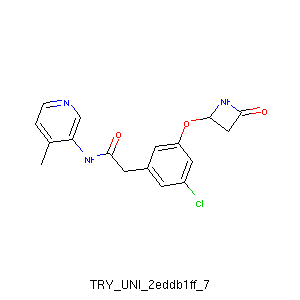

In [21]:
# What do these compounds look like?
Draw.MolToImage(TRY_UNI_2eddb1ff_7, legend='TRY_UNI_2eddb1ff_7')

In [22]:
# Get the top scoring Moonshot compounds vector fingerprint
TRY_UNI_2eddb1ff_7_fp = Chem.RDKFingerprint(TRY_UNI_2eddb1ff_7)

In [23]:
# Get fingerprint vectors for all enumerated compounds
prod_df['product_fps'] = [Chem.RDKFingerprint(mol) for mol in prod_df['product_mols']]

In [24]:
# Get the similarity scores of RCOOH_RNH2 products vs ADA and TRY compounds
prod_df['fp_similarity'] = [DataStructs.FingerprintSimilarity(fp,TRY_UNI_2eddb1ff_7_fp) for fp in prod_df['product_fps']]

In [25]:
prod_df.head()

,product_mols,react_1_mol,react_1_name,react_1_mw,react_1_location,react_1_comments,react_2_mol,react_2_name,react_2_mw,react_2_location,react_2_comments,product_SMILES,product_fps,fp_similarity
228,<rdkit.Chem.rdchem.Mol object at 0x7ff9758dca80>,<rdkit.Chem.rdchem.Mol object at 0x7ff9775a8440>,1-(methylcarbamoyl)cyclopropane-1-carboxylic acid,143.14,RCaH XChem > RCaH XChem > RCaH_1.27_XChem > Ye...,B2,<rdkit.Chem.rdchem.Mol object at 0x7ff977478f80>,(2-chloro-6-fluorophenyl)methanamine,159.59,RCaH XChem > RCaH XChem > RCaH_1.27_XChem > Fr...,A5,CNC(=O)C1(CC1)C(=O)NCc1c(F)cccc1Cl,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",0.233075
229,<rdkit.Chem.rdchem.Mol object at 0x7ff9758dcad8>,<rdkit.Chem.rdchem.Mol object at 0x7ff9775a8440>,1-(methylcarbamoyl)cyclopropane-1-carboxylic acid,143.14,RCaH XChem > RCaH XChem > RCaH_1.27_XChem > Ye...,B2,<rdkit.Chem.rdchem.Mol object at 0x7ff977479030>,"(3,5-dimethyl-1H-pyrazol-4-yl)methanamine dihy...",198.09,RCaH XChem > RCaH XChem > RCaH_1.27_XChem > Ye...,None,CNC(=O)C1(CC1)C(=O)NCc1c(C)n[nH]c1C,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",0.177690
230,<rdkit.Chem.rdchem.Mol object at 0x7ff9758dcb30>,<rdkit.Chem.rdchem.Mol object at 0x7ff9775a8440>,1-(methylcarbamoyl)cyclopropane-1-carboxylic acid,143.14,RCaH XChem > RCaH XChem > RCaH_1.27_XChem > Ye...,B2,<rdkit.Chem.rdchem.Mol object at 0x7ff977479080>,(3-methylthiophen-2-yl)methanamine,127.21,RCaH XChem > RCaH XChem > RCaH_1.27_XChem > Fr...,A6,CNC(=O)C1(CC1)C(=O)NCc1sccc1C,"[0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0.188533
231,<rdkit.Chem.rdchem.Mol object at 0x7ff9758dcb88>,<rdkit.Chem.rdchem.Mol object at 0x7ff9775a8440>,1-(methylcarbamoyl)cyclopropane-1-carboxylic acid,143.14,RCaH XChem > RCaH XChem > RCaH_1.27_XChem > Ye...,B2,<rdkit.Chem.rdchem.Mol object at 0x7ff9774790d0>,(4-aminooxan-4-yl)methanol,131.18,RCaH XChem > RCaH XChem > RCaH_1.27_XChem > Ye...,E4,CNC(=O)C1(CC1)C(=O)NC1(CO)CCOCC1,"[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ...",0.187123
232,<rdkit.Chem.rdchem.Mol object at 0x7ff9758dcbe0>,<rdkit.Chem.rdchem.Mol object at 0x7ff9775a8440>,1-(methylcarbamoyl)cyclopropane-1-carboxylic acid,143.14,RCaH XChem > RCaH XChem > RCaH_1.27_XChem > Ye...,B2,<rdkit.Chem.rdchem.Mol object at 0x7ff977479120>,(4-bromophenyl)methanamine hydrochloride,222.51,RCaH XChem > RCaH XChem > RCaH_1.27_XChem > Ye...,D6,CNC(=O)C1(CC1)C(=O)NCc1ccc(Br)cc1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",0.175236


(array([138., 245., 412., 670., 478., 160.,  32.,  16.,   1.,   4.]),
 array([0.04030227, 0.09331991, 0.14633756, 0.1993552 , 0.25237285,
        0.3053905 , 0.35840814, 0.41142579, 0.46444343, 0.51746108,
        0.57047872]),
 <BarContainer object of 10 artists>)

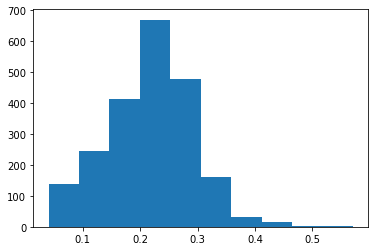

In [26]:
# Let's plot the results to get an idea of what the disctribution of scores are like
import matplotlib.pyplot as plt
plt.hist(prod_df['fp_similarity'])

In [27]:
# Get the top 96 scoring compounds for synthesis
final_prod_df = prod_df.nlargest(96,'fp_similarity')

In [28]:
final_prod_df.head()

,product_mols,react_1_mol,react_1_name,react_1_mw,react_1_location,react_1_comments,react_2_mol,react_2_name,react_2_mw,react_2_location,react_2_comments,product_SMILES,product_fps,fp_similarity
4650,<rdkit.Chem.rdchem.Mol object at 0x7ff9757d5c90>,<rdkit.Chem.rdchem.Mol object at 0x7ff9775b43f0>,"3-Methoxyphenylacetic acid, 99.5%",166.17,RCaH XChem > RCaH XChem > RCaH_1.27_XChem > Ye...,None,<rdkit.Chem.rdchem.Mol object at 0x7ff97747ac60>,pyridin-3-amine,94.11,RCaH XChem > RCaH XChem > RCaH_1.27_XChem > Ye...,A8,COc1cccc(c1)CC(=O)Nc1cccnc1,"[1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...",0.570479
4624,<rdkit.Chem.rdchem.Mol object at 0x7ff9757d53a0>,<rdkit.Chem.rdchem.Mol object at 0x7ff9775b43f0>,"3-Methoxyphenylacetic acid, 99.5%",166.17,RCaH XChem > RCaH XChem > RCaH_1.27_XChem > Ye...,None,<rdkit.Chem.rdchem.Mol object at 0x7ff97747a440>,5-methylpyridin-3-amine,108.14,RCaH XChem > RCaH XChem > RCaH_1.27_XChem > Ye...,B1,COc1cccc(c1)CC(=O)Nc1cncc(C)c1,"[1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...",0.566919
4168,<rdkit.Chem.rdchem.Mol object at 0x7ff97583b500>,<rdkit.Chem.rdchem.Mol object at 0x7ff9775b4530>,"3-Hydroxyphenylacetic acid, 99+%",152.15,RCaH XChem > RCaH XChem > RCaH_1.27_XChem > Ye...,None,<rdkit.Chem.rdchem.Mol object at 0x7ff97747a440>,5-methylpyridin-3-amine,108.14,RCaH XChem > RCaH XChem > RCaH_1.27_XChem > Ye...,B1,Cc1cncc(c1)NC(=O)Cc1cccc(O)c1,"[1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...",0.521465
4194,<rdkit.Chem.rdchem.Mol object at 0x7ff97583bdf0>,<rdkit.Chem.rdchem.Mol object at 0x7ff9775b4530>,"3-Hydroxyphenylacetic acid, 99+%",152.15,RCaH XChem > RCaH XChem > RCaH_1.27_XChem > Ye...,None,<rdkit.Chem.rdchem.Mol object at 0x7ff97747ac60>,pyridin-3-amine,94.11,RCaH XChem > RCaH XChem > RCaH_1.27_XChem > Ye...,A8,O=C(Cc1cccc(O)c1)Nc1cccnc1,"[1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...",0.519947
4580,<rdkit.Chem.rdchem.Mol object at 0x7ff9757d2450>,<rdkit.Chem.rdchem.Mol object at 0x7ff9775b43f0>,"3-Methoxyphenylacetic acid, 99.5%",166.17,RCaH XChem > RCaH XChem > RCaH_1.27_XChem > Ye...,None,<rdkit.Chem.rdchem.Mol object at 0x7ff977479620>,"2,4,6-trimethylaniline",135.21,RCaH XChem > RCaH XChem > RCaH_1.27_XChem > Ye...,E8,COc1cccc(c1)CC(=O)Nc1c(C)cc(C)cc1C,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...",0.478736


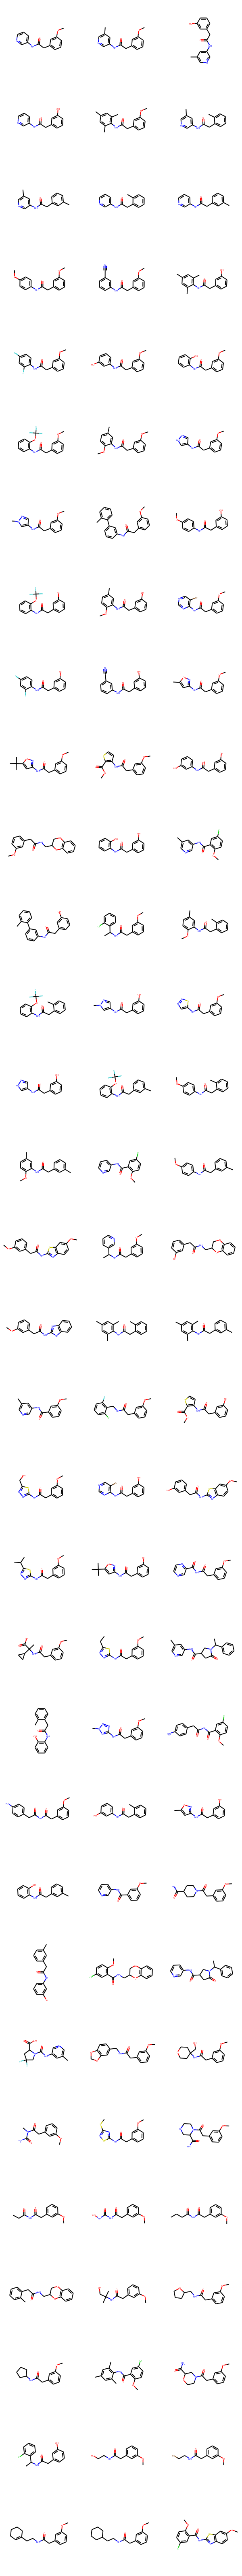

In [29]:
# What do the compounds look like?
Draw.MolsToGridImage([mol for mol in final_prod_df['product_mols']])

In [30]:
# Save to csv file
final_prod_df[['product_SMILES','react_1_name', 'react_1_location','react_1_mw','react_2_name', 'react_2_location','react_2_mw']].to_csv("amide_reagents.csv", index=False)